In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7)

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Lambda, CategoryEncoding

2025-02-09 01:00:48.741974: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 01:00:48.756950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739080848.773678   11317 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739080848.778592   11317 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 01:00:48.795453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [22]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load training

In [3]:
#load shuffled data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


### See classes

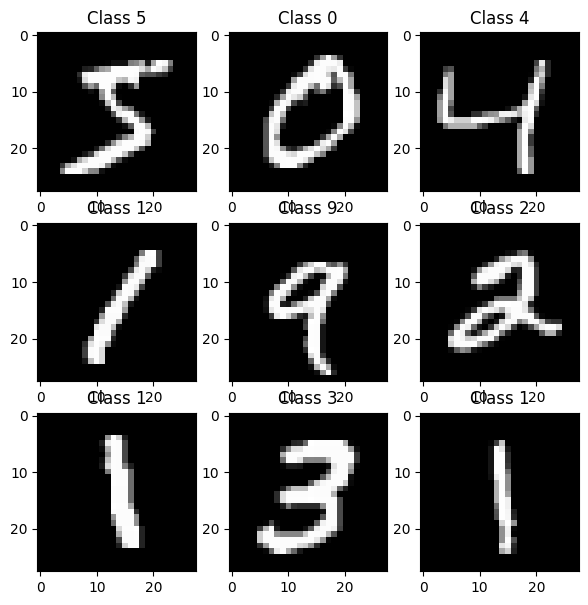

In [4]:
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

### Convert output data to onehot encoding

In [5]:
onehot_encoder = CategoryEncoding(num_tokens=10, output_mode="one_hot")
y_train = onehot_encoder(y_train)
y_test = onehot_encoder(y_test)
y_train[0], y_train.shape, y_test.shape

I0000 00:00:1739080851.345346   11317 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2144 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:f3:00.0, compute capability: 8.6


(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>,
 TensorShape([60000, 10]),
 TensorShape([10000, 10]))

In [6]:
cast_layer = Lambda(lambda x: tf.cast(x, dtype=tf.float32) / 255.0, input_shape=(28,28,1))

/home/evan/virtual-envs/mnist-env/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## LeNet5 Model

In [43]:
layers = [ cast_layer,
              Conv2D(filters=6, kernel_size=5, padding='same', activation='relu'),
              MaxPooling2D(pool_size=2),
              Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu'),
              MaxPooling2D(pool_size=2),
              Flatten(),
              Dense(120, activation='relu'),
              Dropout(0.2),
              Dense(84, activation='relu'),
              Dropout(0.2),
              Dense(10, activation='softmax')
         ]

model = Sequential()
for layer in layers:
    model.add(layer)

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.fit(X_train, y_train,
          batch_size=128, epochs=4,verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.7972 - val_loss: 0.0754
Epoch 2/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1082 - val_loss: 0.0514
Epoch 3/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0729 - val_loss: 0.0425
Epoch 4/4
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0594 - val_loss: 0.0410


In [44]:
predicted_classes = np.argmax(model.predict(X_test), axis=1)
actual_classes = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step    


In [45]:
correct_indices = [i for i, (pred, actual) in enumerate(zip(predicted_classes, actual_classes)) if pred == actual]
incorrect_indices = [i for i, (pred, actual) in enumerate(zip(predicted_classes, actual_classes)) if pred != actual]

In [46]:
len(correct_indices)/(len(correct_indices)+len(incorrect_indices))

0.9859

In [47]:
incorrect_indices[7]

726

Predicted: 5
Actual: 7


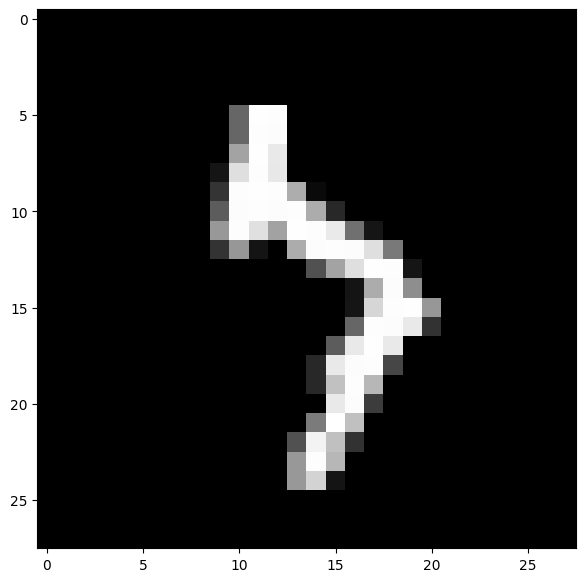

In [48]:
i = 726
plt.imshow(X_test[i], cmap='gray', interpolation='none')
print("Predicted: " + str(predicted_classes[i]))
print("Actual: " + str(actual_classes[i]))

In [17]:
submodel = Sequential(model.layers[:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


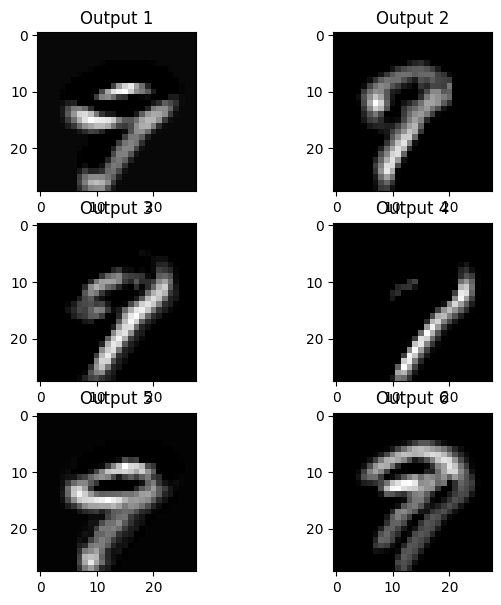

In [18]:
i = 9

conv_output = submodel.predict(X_test[i:i+1])[0]
individual_feature_maps = [conv_output[:, :, i] for i in range(conv_output.shape[-1])]

for i in range(6):
    plt.subplot(3,2, i+1)
    plt.imshow(individual_feature_maps[i], cmap='gray', interpolation='none')
    plt.title("Output {}".format(i+1))

In [19]:
kernels, biass = model.layers[1].get_weights()

In [20]:
kernels[:,:,0,0]

array([[ 0.00513607,  0.1301768 ,  0.32541755,  0.15945461,  0.20261745],
       [ 0.22815113,  0.33788773,  0.13851574,  0.09504891,  0.20173667],
       [ 0.09276366, -0.06616606,  0.02217228,  0.10308699,  0.17201406],
       [-0.31810582, -0.22834685, -0.37500426, -0.06366198, -0.04525086],
       [ 0.00512404, -0.25298467, -0.3338194 , -0.16687723, -0.12384105]],
      dtype=float32)

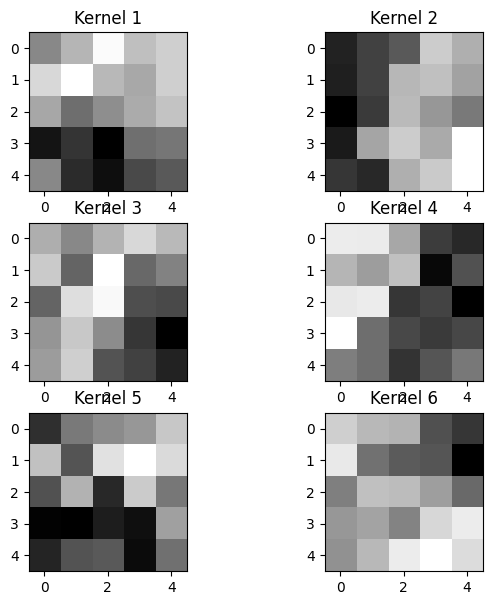

In [21]:
for i in range(6):
    plt.subplot(3,2, i+1)
    plt.imshow(kernels[:,:,0,i], cmap='gray', interpolation='none')
    plt.title("Kernel {}".format(i+1))